# Query the database

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# database credentials
SQL_USERNAME = 'postgres' # replace with your username
SQL_PASSWORD = 'postgres' # replace with your password
SQL_IP = 'localhost' # default postgres ip
SQL_PORT = '5432' # default postgres port
SQL_DBNAME = 'crowdfunding_db' # replace with your dbname

In [3]:
# connect to database
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{SQL_PORT}/{SQL_DBNAME}"
engine = create_engine(connection_string)

In [4]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts
contact_id INTEGER
first_name VARCHAR(20)
last_name VARCHAR(20)
email VARCHAR(50)
last_updated TIMESTAMP

campaigns
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(75)
goal INTEGER
pledged INTEGER
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launched_date DATE
end_date DATE
category_id VARCHAR(4)
subcategory_id VARCHAR(10)
last_updated TIMESTAMP

categories
category_id VARCHAR(4)
category VARCHAR(20)
last_updated TIMESTAMP

sub_categories
subcategory_id VARCHAR(10)
subcategory VARCHAR(20)
last_updated TIMESTAMP



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['categories', 'contacts', 'sub_categories', 'campaigns']

In [7]:
# save references to each table
Contacts = Base.classes.contacts
SubCategories = Base.classes.sub_categories
Campaigns = Base.classes.campaigns
Categories = Base.classes.categories

In [8]:
# create a session
session = Session(engine)

In [9]:
# Find the total number of campaigns
results = session.query(func.count(Campaigns.cf_id)).one()
results[0]

1000

In [10]:
# 1 Find total number of campaigns by category
results = session.query(Categories.category, func.count(Campaigns.cf_id)).\
    join(Campaigns, Categories.category_id == Campaigns.category_id).\
    group_by(Categories.category).\
    order_by(func.count(Campaigns.cf_id).desc()).all()

category_counts = pd.DataFrame(results, columns=['category', 'count'])
category_counts

,category,count
0,theater,344
1,film & video,178
2,music,175
3,technology,96
4,publishing,67
5,games,48
6,food,46
7,photography,42
8,journalism,4


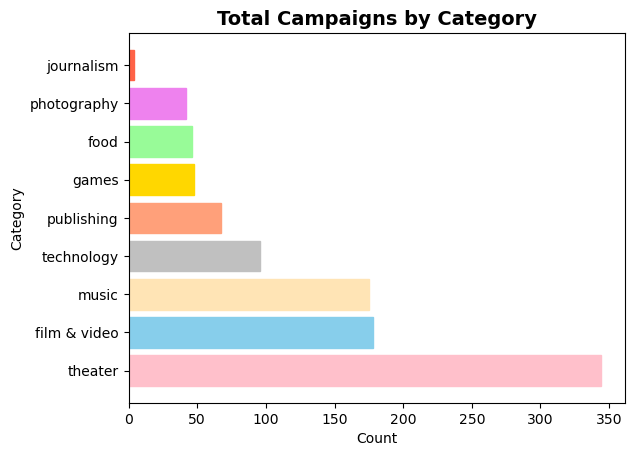

In [11]:
# Data for the horizontal bar graph
category = category_counts['category']
count = category_counts['count']

# Create the figure and axis
fig, ax = plt.subplots()

# Create horizontal bars using Rectangle objects
bars = ax.barh(category, count)

# Define colors for each category
colors = ['pink', 'skyblue', 'moccasin', 'silver', 'lightsalmon', 'gold', 'palegreen', 'violet', 'tomato']
# Set random colors for each bar
for i, bar in enumerate(bars):
    bar.set_color(colors[i])

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Total Campaigns by Category', fontsize=14, fontweight='bold')

# Show the plot
plt.show()

In [12]:
# 2 Find the number of successful campaigns by subcategory
results = session.query(SubCategories.subcategory, func.count(Campaigns.cf_id)).\
    join(Campaigns, SubCategories.subcategory_id == Campaigns.subcategory_id).\
    filter(Campaigns.outcome == 'successful').\
    group_by(SubCategories.subcategory).\
    order_by(func.count(Campaigns.cf_id).desc()).all()

successful_subcategory_counts = pd.DataFrame(results, columns=['subcategory', 'count'])
successful_subcategory_counts.head()

,subcategory,count
0,plays,187
1,rock,49
2,web,36
3,documentary,34
4,wearables,28


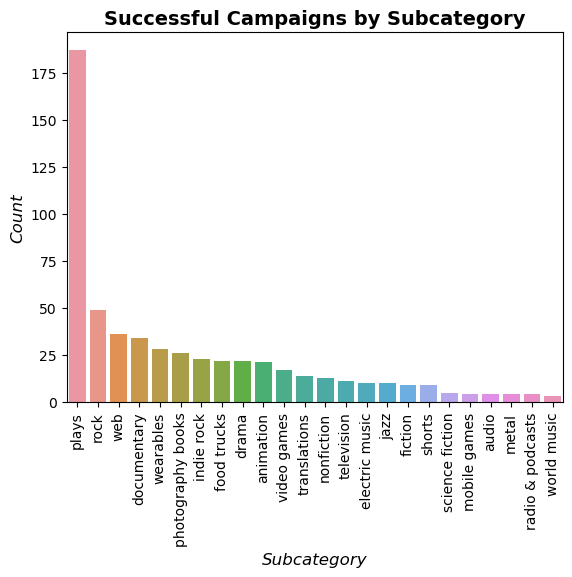

In [13]:
# Plot the number of successful campaigns by subcategory
sns.barplot(x='subcategory', y='count', data=successful_subcategory_counts)

# Add labels and title
plt.xlabel('Subcategory', fontsize=12, fontstyle='italic')
plt.ylabel('Count', fontsize=12, fontstyle='italic')
plt.title('Successful Campaigns by Subcategory', fontsize=14, fontweight='bold')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [14]:
# 3 Find the number of campaigns by outcome
results = session.query(Campaigns.outcome, func.count(Campaigns.cf_id)).\
    group_by(Campaigns.outcome).\
    order_by(func.count(Campaigns.cf_id).desc()).all()

outcome_counts = pd.DataFrame(results, columns=['outcome', 'count'])
outcome_counts

,outcome,count
0,successful,565
1,failed,364
2,canceled,57
3,live,14


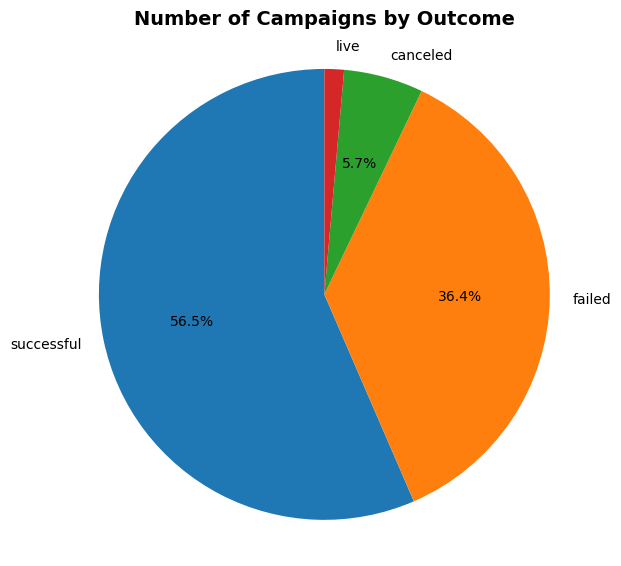

In [15]:
# Data for the pie chart
sizes = outcome_counts['count']
labels = outcome_counts['outcome']

# Format the percentages
def custom_autopct(pct):
    return '{:.1f}%'.format(pct) if pct > 5 else ''
    
# Create the pie chart
plt.pie(sizes, labels=labels, autopct=custom_autopct, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Number of Campaigns by Outcome', fontsize=14, fontweight='bold')

# Adjust the spacing between the pie chart labels and the title
plt.subplots_adjust(top=1.2)  # Increase or decrease the top margin as needed

# Show chart
plt.show()

In [16]:
# 4 Find the number of successful and failed campaigns by country
results = session.query(Campaigns.country, func.count(Campaigns.cf_id)).\
    filter(Campaigns.outcome == 'successful').\
    group_by(Campaigns.country).\
    order_by(func.count(Campaigns.cf_id).desc()).all()

successful_by_country = pd.DataFrame(results, columns=['country', 'count'])

results = session.query(Campaigns.country, func.count(Campaigns.cf_id)).\
    filter(Campaigns.outcome == 'failed').\
    group_by(Campaigns.country).\
    order_by(func.count(Campaigns.cf_id).desc()).all()

failed_by_country = pd.DataFrame(results, columns=['country', 'count'])

# Merge the data frames on the 'Country' column
country_merged_df = pd.merge(successful_by_country, failed_by_country, on='country', how='left')

# Rename the column names in the merged dataframe
country_merged_df = country_merged_df.rename(columns={'count_x': 'Successful Campaigns', 'count_y': 'Failed Campaigns'})

# Print merged dataframe 
country_merged_df

,country,Successful Campaigns,Failed Campaigns
0,US,436,274
1,GB,28,18
2,IT,26,19
3,AU,24,16
4,CA,22,19
5,DK,17,12
6,CH,12,6


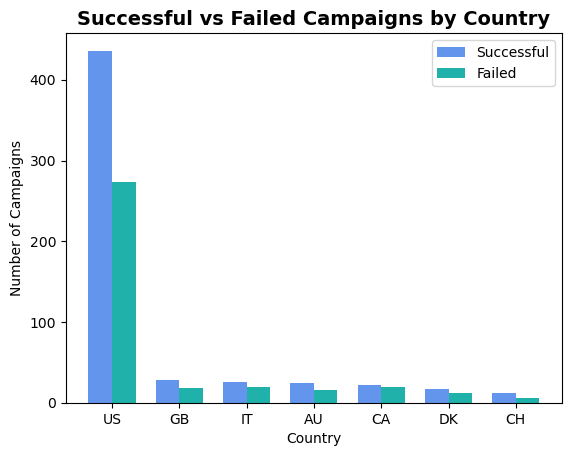

In [17]:
# Data for the double bar graph
country = country_merged_df['country']
successful_campaign = country_merged_df['Successful Campaigns']
failed_campaign = country_merged_df['Failed Campaigns']		

# Create the figure and axis:
fig, ax = plt.subplots()

# Define the width of the bars and the x locations for the bars:
bar_width = 0.35
x = range(len(country))

# Create the first set of bars:
bars1 = ax.bar(x, successful_campaign, width=bar_width, color='cornflowerblue', label='Successful')
# Create the second set of bars with an offset:
bars2 = ax.bar([i + bar_width for i in x], failed_campaign, width=bar_width, color='lightseagreen', label='Failed')

# Set the labels and title:
ax.set_xlabel('Country')
ax.set_ylabel('Number of Campaigns')
ax.set_title('Successful vs Failed Campaigns by Country', fontsize=14, fontweight='bold')
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(country)
ax.legend()

# Show the plot:
plt.show()

In [18]:
# close the session and kill the engine
session.close()
engine.dispose()